<a href="https://colab.research.google.com/github/nekoneko02/rainforcement-learning/blob/main/MountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium
!pip install torchrl
!apt update && apt install xvfb
!pip install gym-notebook-wrapper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 28.5 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,564 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes

In [2]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

gym_name = "MountainCar-v0"
env = gym.make(gym_name)

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# envの使い方

In [3]:
state, info = env.reset()
print(f"state:{state}")
state_space = len(state)
print(f"state_space:{state_space}")
action_space = env.action_space.n
print(f"action_space:{action_space}")

action = 0
next_status, reward, done, truncation, info = env.step(action)
print(f"next_status:{next_status}")
print(f"reward:{reward}")
print(f"done:{done}")
print(f"truncation:{truncation}")
print(f"info:{info}")

state:[-0.5290063  0.       ]
state_space:2
action_space:3
next_status:[-0.52996576 -0.00095945]
reward:-1.0
done:False
truncation:False
info:{}


# Q Net

In [4]:
class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(state_space, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(state_space, 64)
        self.fc2 = nn.Linear(64, action_space)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [82]:
from torchrl.data import TensorDictReplayBuffer, ListStorage
class ReplayBufferWrapper(TensorDictReplayBuffer):
    def sample(self, include_info):
      data = super().sample(include_info = include_info)
      state = torch.stack([x["state"][0] for x in data])
      action = torch.tensor([x["action"] for x in data])
      reward = torch.tensor([x["reward"] for x in data])
      next_state = torch.stack([x["next_state"][0] for x in data])
      done = torch.tensor([x["done"] for x in data], dtype = torch.int32)
      action_prob = torch.tensor([x["action_prob"] for x in data])
      return state, action, reward, next_state, done, action_prob

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
from torchrl.data.replay_buffers.samplers import PrioritizedSampler
from tensordict import TensorDict
import copy

class QLearningAgent:
  def __init__(self):
    self.gamma = 0.9
    self.lr = 0.01
    self.init_epsilon = 1
    self.min_epsilon = 0.1
    self.epsilon_decay = 0.9995
    self.epsilon = self.init_epsilon
    self.action_size = 2
    self.buffer_size = 10000
    self.batch_size = 32
    self.inf_zero = 1e-8

    self.replay_buffer = ReplayBufferWrapper(
      storage=ListStorage(max_size=self.buffer_size),
      sampler=PrioritizedSampler(max_capacity=self.buffer_size, alpha=0.8, beta=1.1),
      collate_fn=lambda x: x,
      batch_size=self.batch_size,
    )
    # q_net
    self.q_net = ValueNet().to(device)
    self.q_net_target = ValueNet().to(device)
    self.optimizer_q = optim.Adam(self.q_net.parameters(), lr=self.lr)
    # pi
    self.pi_net = PolicyNet().to(device)
    self.pi_net_target = PolicyNet().to(device)
    self.optimizer_pi = optim.Adam(self.pi_net.parameters(), lr=self.lr)
  def select_action(self, state, epsilon_greedy = True):
    # epsilonの更新
    self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    state = state[np.newaxis, :]
    action_probs = self.pi_net(state)[0]
    if epsilon_greedy and np.random.rand() < self.epsilon:
      action = np.random.choice(self.action_size)
      return action, self.epsilon / self.action_size + ( 1 - self.epsilon ) * action_probs[action]
    action = np.random.choice(len(action_probs), p = action_probs.cpu().detach().numpy())
    return action, self.epsilon / self.action_size + ( 1 - self.epsilon ) * action_probs[action]
  def sync_qnet(self):
    self.q_net_target = copy.deepcopy(self.q_net)
    self.pi_net_target = copy.deepcopy(self.pi_net)
  def update(self, state, action, reward, next_state, done, action_prob):
    state = state[np.newaxis, :]
    next_state = next_state[np.newaxis, :]
    q = self.q_net(state)
    next_q = self.q_net(next_state) * (1 - done)
    target = reward + self.gamma * next_q
    target = torch.abs(target)
    target = target.detach()

    data = TensorDict({
      "state": torch.tensor(state, dtype=torch.float32),
      "action": torch.tensor([[action]], dtype=torch.int64),
      "next_state": torch.tensor(next_state, dtype=torch.float32),
      "reward": torch.tensor([[reward]], dtype=torch.float32),
      "done": torch.tensor([[done]], dtype=torch.int32),
      "action_prob": torch.tensor([[action_prob]], dtype=torch.float32),
      "td_error": target
    }, [1])
    self.replay_buffer.add(data)

    if len(self.replay_buffer) < self.batch_size:
      return 0, 0
    state_batch, action_batch, reward_batch, next_state_batch, done_batch, action_prob_batch = self.replay_buffer.sample(include_info=False)
    #print(    state_batch.shape, action_batch.shape, reward_batch.shape, next_state_batch.shape, done_batch.shape, action_prob_batch.shape)

    # loss_qの計算
    q = self.q_net(state_batch)
    next_q = self.q_net_target(next_state_batch)[:, 0]
    next_q = next_q * (1 - done_batch)

    target = reward_batch + self.gamma * next_q
    target = target.unsqueeze(1).detach()
    loss_q = F.mse_loss(q, target)

    # loss_piの計算
    action_prob_current_batch = self.pi_net(state_batch)
    #print(action_prob_current_batch.shape, np.arange(self.batch_size), action_batch)
    action_prob_current_batch = action_prob_current_batch[np.arange(self.batch_size), action_batch]
    action_prob_current_batch = action_prob_current_batch[:, np.newaxis]
    action_prob_batch = action_prob_batch[:, np.newaxis] + self.inf_zero
    beta = action_prob_current_batch / action_prob_batch
    delta = target - q#reward + self.gamma * self.q_net_target(next_state) * (1 - done) - self.q_net(state)
    delta = (beta * delta).detach()
    loss_pi = - delta * torch.log(action_prob_current_batch + self.inf_zero)
    #print(action_prob_current_batch.shape, beta.shape, delta.shape, loss_pi.shape)
    loss_pi = loss_pi.mean()
    """
    # loss_qの計算
    state = state[np.newaxis, :]
    next_state = next_state[np.newaxis, :]
    q = self.q_net(state)
    next_q = self.q_net(next_state) * (1 - done)

    target = reward + self.gamma * next_q
    target = target.detach()
    loss_q = F.mse_loss(q, target)

    # loss_piの計算
    action_prob_current = self.pi_net(state)[0, action]
    beta = action_prob_current / action_prob
    delta = target - q#reward + self.gamma * self.q_net_target(next_state) * (1 - done) - self.q_net(state)
    delta = (beta * delta).detach()
    loss_pi = - delta * torch.log(action_prob_current)
    #loss_pi = loss_pi.mean()
    """
    self.optimizer_q.zero_grad()
    self.optimizer_pi.zero_grad()
    loss_q.backward()
    loss_pi.backward()
    self.optimizer_q.step()
    self.optimizer_pi.step()

    return loss_q, loss_pi

# training

In [90]:
agent = QLearningAgent()

episodes = 40
sync_interval = 2
loss_history = []
reward_history = []

m = 1
g = 9.8

for episode in range(episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32).to(device)
    done = False
    total_loss_q, total_loss_pi, total_reward, max_hight, cnt = 0, 0, 0, 0, 0

    while not done:
        action, action_prob = agent.select_action(state)
        next_state, reward, done, truncation, info = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)

        x = next_state[0]
        y = torch.sin(x * np.pi)
        v = next_state[1]
        E = m * v ** 2
        U = m * g * y
        reward = reward + E + U
        loss_q, loss_pi = agent.update(
            state = state,
            action = action,
            reward = reward,
            next_state = next_state,
            done = done,
            action_prob = action_prob
        )
        #print(loss_q, loss_pi, reward)
        total_reward += reward
        total_loss_q += loss_q
        total_loss_pi += loss_pi
        cnt += 1
        state = next_state
        if cnt % 1000 == 0 :
          print(f"episode:{episode}, loss:{total_loss_q / cnt}, {total_loss_pi / cnt}, reward: {total_reward / cnt}, cnt: {cnt}")

    if episode % sync_interval == 0:
      agent.sync_qnet()

    reward_history.append(total_reward / cnt)
    loss_history.append(total_loss_q / cnt)
    print(f"episode:{episode}, loss:{total_loss_q / cnt}, {total_loss_pi / cnt}, reward: {total_reward / cnt}, cnt: {cnt}")

<ipython-input-87-99c1a2d692d7>:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "state": torch.tensor(state, dtype=torch.float32),
<ipython-input-87-99c1a2d692d7>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "next_state": torch.tensor(next_state, dtype=torch.float32),


episode:0, loss:1.9031785726547241, -0.07129579037427902, reward: -8.870711326599121, cnt: 1000
episode:0, loss:0.9599330425262451, -0.036775585263967514, reward: -8.245779991149902, cnt: 2000
episode:0, loss:0.9345129132270813, -0.03580574318766594, reward: -8.033823013305664, cnt: 2055
episode:1, loss:0.5746482014656067, -0.00010452100832480937, reward: -10.097601890563965, cnt: 1000
episode:1, loss:0.3098253607749939, -0.0014420549850910902, reward: -9.32136058807373, cnt: 2000
episode:1, loss:0.22016817331314087, -0.002095542848110199, reward: -7.076649188995361, cnt: 3000
episode:1, loss:0.1799168586730957, -0.002274709055200219, reward: -6.015114784240723, cnt: 4000
episode:1, loss:0.15728221833705902, -0.0023121226113289595, reward: -5.311939239501953, cnt: 5000
episode:1, loss:0.13602642714977264, -0.00249915337190032, reward: -4.821650505065918, cnt: 6000
episode:1, loss:0.12099739164113998, -0.0024375817738473415, reward: -4.483962059020996, cnt: 7000
episode:1, loss:0.113047

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (1000,) and (45,)

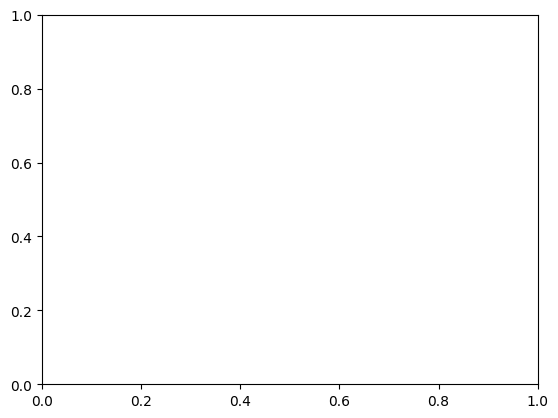

In [91]:
plt.plot(range(episodes),[x.cpu().detach().numpy() for x in loss_history])

ValueError: x and y must have same first dimension, but have shapes (1000,) and (45,)

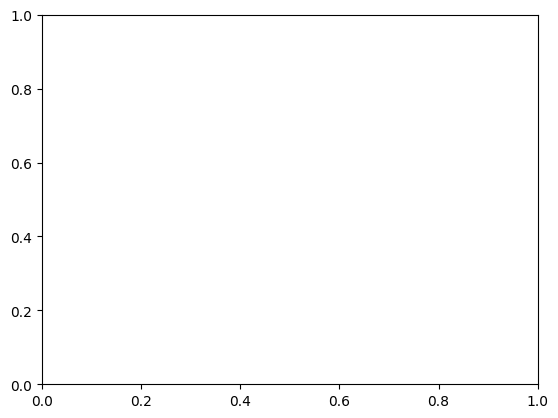

In [92]:
plt.plot(range(episodes),[x.cpu().detach().numpy() for x in reward_history])

# play by agent

In [93]:
import numpy as np

env = gym.make(gym_name, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(env, video_folder="./", disable_logger=True)
state, _ = env.reset()
done = False
renders = []
play_time = 0

while not done and play_time < 1000:
    play_time += 1
    state = torch.tensor(state, dtype=torch.float32).to(device)
    #action = np.random.choice([0,1])
    action, _ = agent.select_action(state, epsilon_greedy= False)
    state, reward, done, truncation, info = env.step(action)
    env.render()
env.close()
print(f"play_time:{play_time}")

/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_n

play_time:169


# 動画を描画する

In [94]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('./rl-video-episode-0.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="100%" height="100%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
!rm ./rl-video-episode*.mp4

In [95]:
%%bash
apt-get install git

Reading package lists...
Building dependency tree...
Reading state information...
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [96]:
%%bash
git --version
git config --global user.email "taka.flemish.giant@gmail.com"
git config --global user.name "Takaya Otsu"

git version 2.34.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
%ls **/MountainCar.ipynb

ls: cannot access '**/MountainCar.ipynb': No such file or directory
